# <center>Mobile Games: A/B Testing & Player Retention </center>

## Table of Contents

1. **[Project Background](#1)**
2. **[About the Data](#2)**
3. **[EDA-Analyzing Player Behavior ](#3)**
4. **[Correlation Analysis](#4)**
5. **[Comparing 1-day Retention](#5)**
6. **[Comparing 7-day Retention](#6)**
7. **[Conclusion](#7)**

## Part 1. Project Background <a name= '1'></a>

<p><a href="https://www.facebook.com/cookiecatsgame">Cookie Cats</a> is a hugely popular mobile puzzle game developed by <a href="http://tactile.dk">Tactile Entertainment</a>. It's a classic "connect three"-style puzzle game where the player must connect tiles of the same color to clear the board and win the level. It also features singing cats. Check out this short demo:</p>
<p><a href="https://youtu.be/GaP5f0jVTWE"><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/cookie_cats_video.jpeg" style="width: 500px"></a></p>
<p>As players progress through the levels of the game, they will <strong>occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress</strong>. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in that the player's enjoyment of the game being increased and prolonged.<p>But where should the gates be placed? Initially the first gate was placed at level 30. <strong>In this project, we're going to analyze an AB-test where we moved the first gate in Cookie Cats from level 30 to level 40. In particular, we will look at the impact on player retention.</strong> </p>
<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/cc_gates.png" alt=""></p>

## Part 2. About the Data  <a name= '2'></a>

### 2.1 Load the AB-test data

In [233]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [234]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

df = pd.read_csv('/content/drive/My Drive/Materials/cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


<p>The data is from 90,189 players that installed the game while the AB-test was running. The variables are:</p>
<ul>
<li><code>userid</code> - a unique number that identifies each player.</li>
<li><code>version</code> - whether the player was put in the control group (<code>gate_30</code> - a gate at level 30) or the test group (<code>gate_40</code> - a gate at level 40).</li>
<li><code>sum_gamerounds</code> - the number of game rounds played by the player during the first week after install
<li><code>retention_1</code> - did the player come back and play 1 day after SEE THE GATE?</li>
<li><code>retention_7</code> - did the player come back and play 7 days after SEE THE GATE?</li>
</ul>
<p>When a player installed the game, he or she was randomly assigned to either <code>gate_30</code> or <code>gate_40</code>. </p>

### 2.2 Check missing values

In [235]:
# check the size of the datset
df.shape

(90189, 5)

* There are 90189 rows and 5 columns in the dataset.

In [236]:
# data inspection
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [237]:
#check if there is any missing values
df.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

Luckily, there is no missing value in this dataset.

In [238]:
#check if there is any duplicate rows
duplicateRows = df[df.duplicated()]
#view duplicate rows
duplicateRows

,userid,version,sum_gamerounds,retention_1,retention_7


Luckily, there is no duplicate rows in this dataset.


### 2.3 Count the number of players in each group

In [239]:
# check how many data points in the 2 groups "gate_30" & "gate_40"
df.groupby('version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


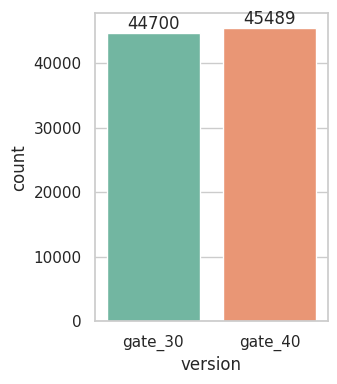

In [240]:
# Visualize them using bar chart
plt.figure(figsize=(3,4))
ax = sns.countplot(x='version',data=df,palette="Set2")
for item in ax.containers:
    ax.bar_label(item,)

In [241]:
# Summarize the percentage of Gate_30 and Gate_40
print('Gate_30 accounts for', round(df['version'].value_counts()['gate_30']/len(df) * 100,2), '% of the dataset')
print('Gate_40 accounts for', round(df['version'].value_counts()['gate_40']/len(df) * 100,2), '% of the dataset')

Gate_30 accounts for 49.56 % of the dataset
Gate_40 accounts for 50.44 % of the dataset


<p>* When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40. The number of players is roughly the same in the control and test group.

### 2.4 Change 'retention_1' and 'retention-7' to numerical values for further analysis

In [242]:
# Replace True with 1 and False with 0 in 'gate_30' and 'gate_40' columns
df['retention_1'].replace({True: 1, False: 0}, inplace=True)
df['retention_7'].replace({True: 1, False: 0}, inplace=True)

# Check the modified DataFrame
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1


## Part 3. Exploratory Data Analysis --- Analyzing Player Behavior  <a name= '3'></a>

We will plot a boxplot to visualize the distribution of 'sum_gamerounds', which would give us a rough idea of how many game rounds were played by a player during the first week after installing the game.

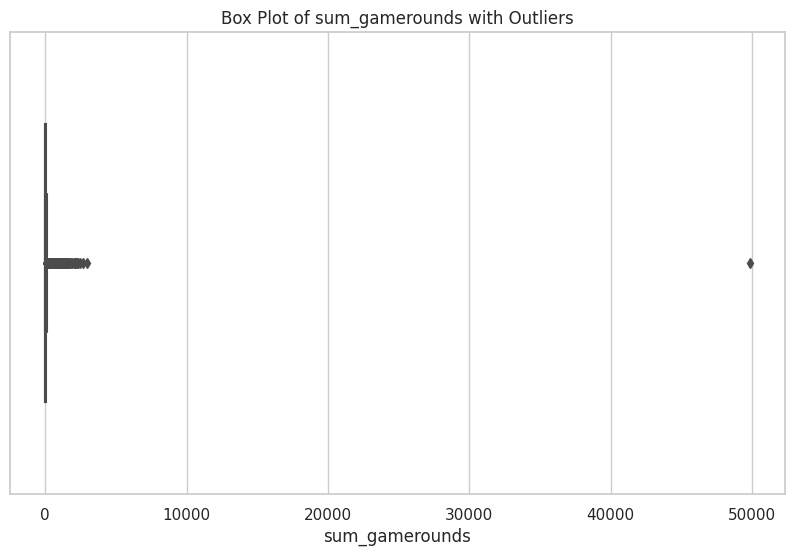

In [243]:
# check the distribution of 'sum_gamerounds'
# Create a box plot to visualize outliers
# Set up Seaborn style
sns.set(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Create a box plot with enhanced styling
sns.boxplot(x=df['sum_gamerounds'], color='red', width=0.6)

# Add a title and labels
plt.title('Box Plot of sum_gamerounds with Outliers')
plt.xlabel('sum_gamerounds')

# Show the plot
plt.show()

Clearly, there is an outlier. This player played about 50,000 game rounds during the first week! Due to this outlier, this boxplot is extremely skewed and not very informative. To learn about the behavior of the majority of the players, we will have a close look at the values and outliers in this column 'sum_gamerounds'.

In [244]:
# a statistical summay
df['sum_gamerounds'].describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

Lower Outer Bound: -64.0
Upper Outer Bound: 120.0


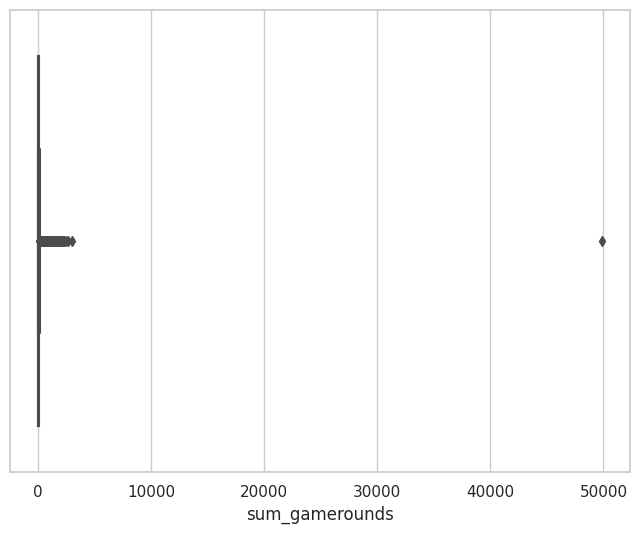

In [245]:
# Set up Seaborn style
sns.set(style="whitegrid")

# Create a box plot to visualize the data and outliers
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['sum_gamerounds'])

# Calculate Q1, Q3, and IQR
q1 = df['sum_gamerounds'].quantile(0.25)
q3 = df['sum_gamerounds'].quantile(0.75)
iqr = q3 - q1

# Calculate outer bounds for outliers
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

print("Lower Outer Bound:", lower_bound)
print("Upper Outer Bound:", upper_bound)

# Show the plot
plt.show()

* 'sum_gameroungs' >120 care considered as outliers. Let's check how many data points are there in the dataset.

In [246]:
# Count the values greater than 120 in the 'sum_gamerounds' column
count_greater_than_120 = (df['sum_gamerounds'] > 120).sum()

print("Number of values > 120:", count_greater_than_120)

Number of values > 120: 10177


* There are 10177 data points whose value of 'sum_gamerounds'>120. We cannot drop them are. Let's take a close look at all the 'outliers'.

In [247]:
#Filter the rows where the value is 49854 in 'sum_gamerounds' column which is the max value in the column
rows_with_value_49854 = df[df['sum_gamerounds'] == 49854]
# Display the rows
print(rows_with_value_49854)

        userid  version  sum_gamerounds  retention_1  retention_7
57702  6390605  gate_30           49854            0            1


In [248]:
# Drop the rows where the value is 49854 in the 'sum_gamerounds' column
df = df[df['sum_gamerounds'] != 49854]

#Recheck the modified DataFrame
df['sum_gamerounds'].describe()

count    90188.000000
mean        51.320253
std        102.682719
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max       2961.000000
Name: sum_gamerounds, dtype: float64

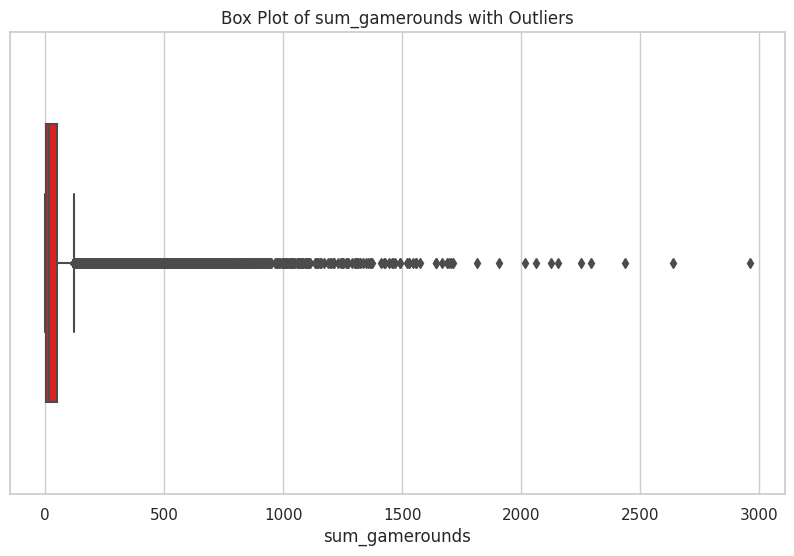

In [249]:
# recheck the distribution of 'sum_gamerounds'
# Create a box plot to visualize outliers
# Set up Seaborn style
sns.set(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Create a box plot with enhanced styling
sns.boxplot(x=df['sum_gamerounds'], color='red', width=0.6)

# Add a title and labels
plt.title('Box Plot of sum_gamerounds with Outliers')
plt.xlabel('sum_gamerounds')

# Show the plot
plt.show()

In [250]:
# Create a new dataset with rows where 'sum_gamerounds' > 120
df1 = df[df['sum_gamerounds'] > 120]

# Check the new dataset
df1['sum_gamerounds'].describe()

count    10176.000000
mean       266.298054
std        188.197663
min        121.000000
25%        153.000000
50%        204.000000
75%        308.250000
max       2961.000000
Name: sum_gamerounds, dtype: float64

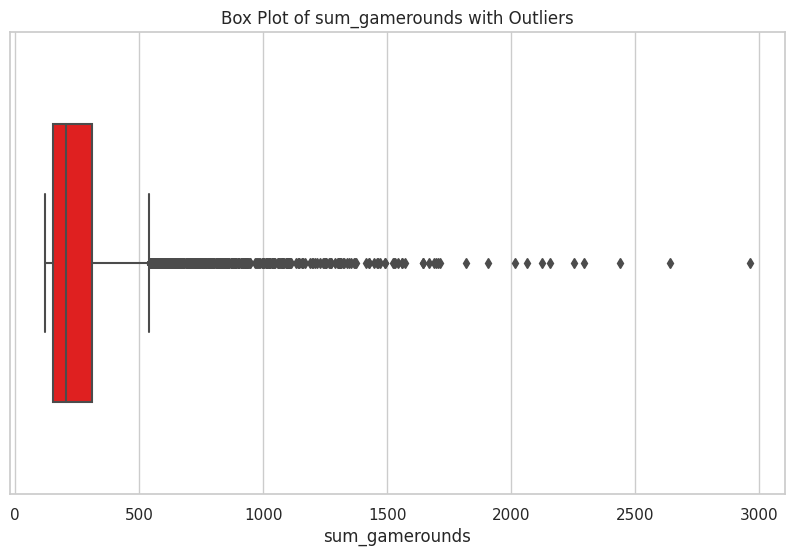

In [251]:

# Create a box plot to visualize outliers
# Set up Seaborn style
sns.set(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Create a box plot with enhanced styling
sns.boxplot(x=df1['sum_gamerounds'], color='red', width=0.6)

# Add a title and labels
plt.title('Box Plot of sum_gamerounds with Outliers')
plt.xlabel('sum_gamerounds')

# Show the plot
plt.show()

* From above, we can see that most outliers are lower than 600. Let's see how many data points are greater than 600.

In [252]:
# Count the values greater than 600 in the 'sum_gamerounds' column
count_greater_than_600 = (df['sum_gamerounds'] > 600).sum()

print("Number of values > 600:", count_greater_than_600)

Number of values > 600: 510


* Considering that there are more than 90,000 data points in our dataset. So as for the extreme outliers we will drop them.

In [253]:
# Drop the rows where the value is greater than 1000 in the 'sum_gamerounds' column
df = df[df['sum_gamerounds'] <= 600]

# Check the modified DataFrame
df['sum_gamerounds'].describe()

count    89678.000000
mean        46.671034
std         78.743355
min          0.000000
25%          5.000000
50%         16.000000
75%         50.000000
max        600.000000
Name: sum_gamerounds, dtype: float64

* We can see there is huge difference between the median and the mean and the mode of the dataset. The mean and median is hugely affected by the outliers.

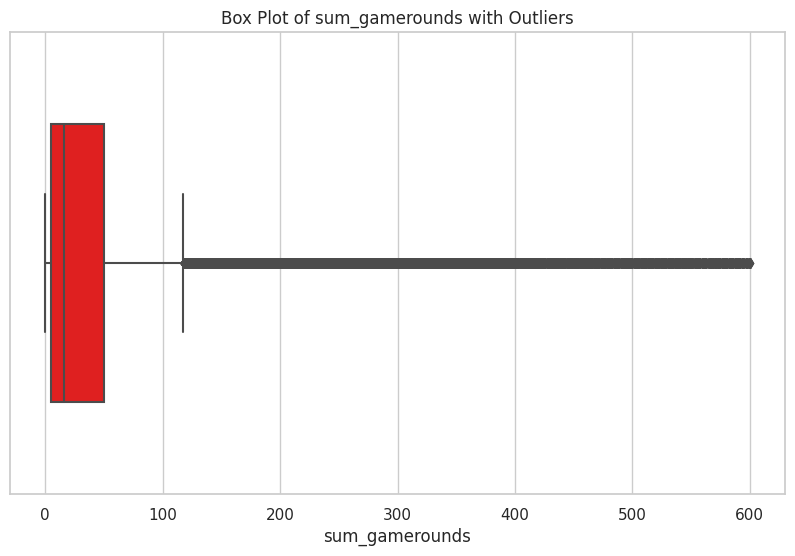

In [254]:
# recheck the distribution of 'sum_gamerounds'
# Create a box plot to visualize outliers
# Set up Seaborn style
sns.set(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Create a box plot with enhanced styling
sns.boxplot(x=df['sum_gamerounds'], color='red', width=0.6)

# Add a title and labels
plt.title('Box Plot of sum_gamerounds with Outliers')
plt.xlabel('sum_gamerounds')

# Show the plot
plt.show()

In [255]:
# Group and calculate the counts for each value in 'sum_gamerounds' column
grouped_counts = df.groupby('sum_gamerounds').size().reset_index(name='counts')
# Plot the distribution of players that played 0 to 100 game rounds during their first week playing the game.
# Create a line plot using Plotly Express
fig = px.line(grouped_counts[:100], x='sum_gamerounds', y='counts', title='Counts of each sum_gamerounds value')

# Customize the axis labels
fig.update_layout(xaxis_title='sum_gamerounds', yaxis_title='Counts')

# Show the plot
fig.show()

**Summary**


As we examine the data, it becomes evident that half of the players engaged in fewer than 16 game rounds within the initial week post installation. Moreover, a substantial 75% of players participated in fewer than 51 rounds.

A notable observation emerges when considering the group of players—almost 4000 in number—who refrained from partaking in even a single round post installation. Several factors might account for this behavior:

**Multi-game Distraction**: These individuals may have downloaded multiple new games simultaneously, diverting their attention and interest.
**First Impressions**: It's plausible that upon encountering the app's design, interface, or auditory features, some users chose to discontinue before engaging with the actual gameplay.
**Yet to Begin**: A third possibility is that they have yet to commence playing, indicating that they are potential future participants.


Another noteworthy figure is the 14,000 players who played less than three rounds. This subgroup's reasons for discontinuation might include:

**Lack of Enjoyment**: The most common cause might be that these players didn't derive enjoyment from the game.
Misaligned Expectations: Players' expectations may not have matched the actual gameplay experience.
**Minimal Challenge**: It's also plausible that the game was perceived as too simple, resulting in boredom.

Understanding the substantial attrition rate early in the game is crucial. Tactile Entertainment has an opportunity to gather player insights through methods such as in-app surveys. By obtaining feedback, they can uncover valuable insights to refine and enhance the game's appeal, potentially leading to improved player retention rates.

The distribution is highly skewed, with a long tail on the right. A huge number of players played fewer than 20 rounds and left the game. For rounds greater than 60, the number of players stayed steady at about 300.

## Part 4. Correlation Analysis  <a name= '3'></a>

In [256]:
# correlation analysis(exclude userid column)
columns_to_include = df.columns[df.columns != 'userid']

<ipython-input-257-20cbf1728dc0>:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



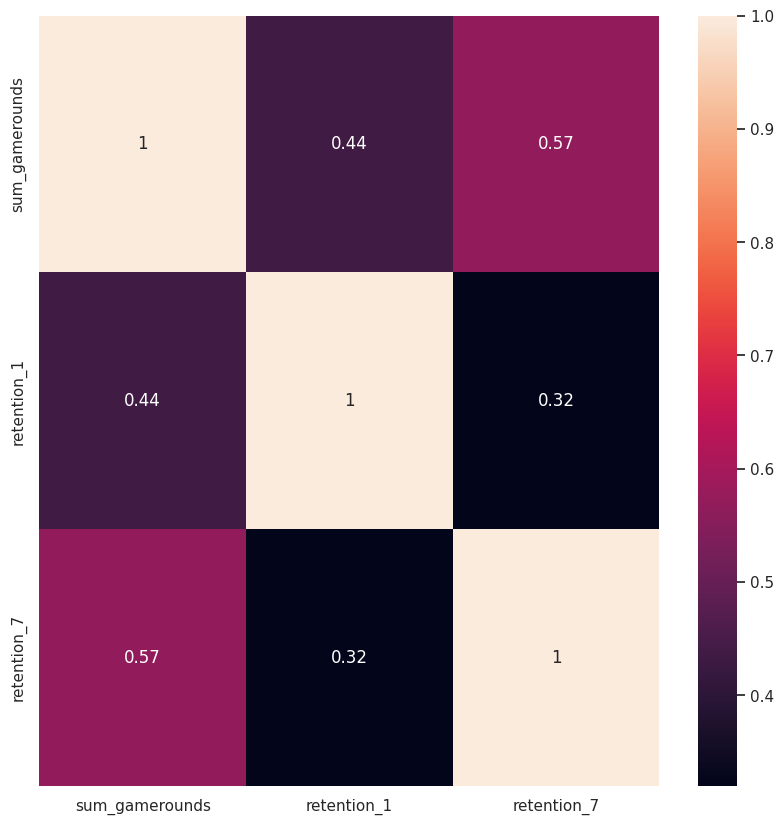

In [257]:
# correlation heatmap
plt.figure(figsize=(10,10))
sns.heatmap(df[columns_to_include].corr(), annot=True);

* From the heatmap above, it's evident that the 'sum_gamerounds' variable exhibits a positive correlation with both 'retention_1' and 'retention_7'. Furthermore, there is also a noticeable positive correlation between 'retention_1' and 'retention_7'. Of note is the fact that 'sum_gamerounds' demonstrates the strongest positive correlation with 'retention_7'.

## Part 5. Comparing 1-day Retention  <a name= '4'></a>

<p>In the plot above we can see that some players install the game but then never play it, some players just play a couple of game rounds in their first week, and some get really hooked! What we want is for players to like the game and to get hooked.
<p>A common metric in the video gaming industry for how fun and engaging a game is <strong>1-day retention: the percentage of players that comes back and plays the game one day after they have installed it.</strong>  The higher 1-day retention is, the easier it is to retain players and build a large player base. </p>

#### *Overall 1-day retention*

In [258]:
df['retention_1'].sum() / df['retention_1'].count() # When using .sum(), T/F will first be converted to 1/0.

# Equivalent to df['retention_1'].mean()
# Mean is calculated by summing the values and dividing by the total number of values.

0.4422266330649658

A little less than half of the players come back one day after installing the game. Now that we have a benchmark, let's look at how 1-day retention differs between the two AB-groups.

#### *1-day retention for each AB-group*

In [269]:
df.groupby('version')['retention_1'].mean()

version
gate_30    0.445359
gate_40    0.439147
Name: retention_1, dtype: float64

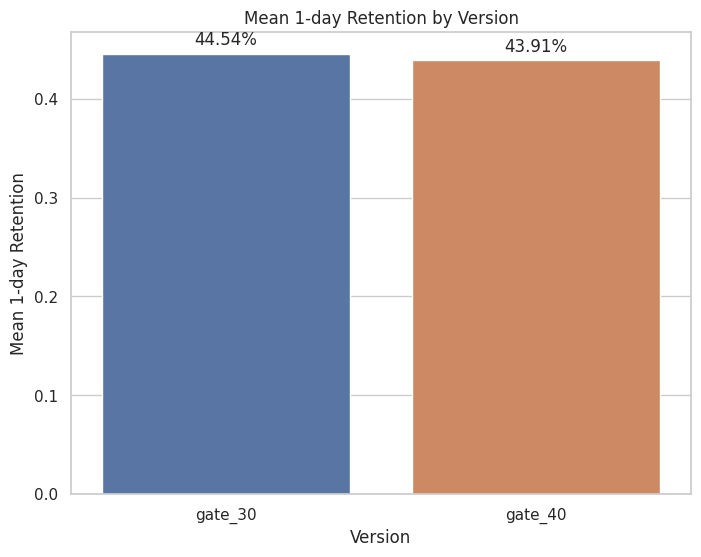

In [271]:
# Calculate mean 1-day retention for each version
retention_1_mean = df.groupby('version')['retention_1'].mean()

# Convert the result to a DataFrame for visualization
retention_1_mean = retention_1_mean.reset_index()
retention_1_mean.columns = ['version', 'Mean 1-day Retention']

# Set up Seaborn style
sns.set(style="whitegrid")

# Create a bar plot for mean 1-day retention
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='version', y='Mean 1-day Retention', data=retention_1_mean)
plt.xlabel('Version')
plt.ylabel('Mean 1-day Retention')
plt.title('Mean 1-day Retention by Version')

# Adding value annotations on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2%}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

* It's apparent that a marginal decrease in 1-day retention was observed when the gate was shifted to level 40 (44.2%), compared to the baseline when it stood at level 30 (44.8%). Although this shift is modest, it's essential to acknowledge that even minor fluctuations in retention rates can wield substantial influence. Yet, while the observed data presents a difference, it's vital to assess the degree of confidence regarding the assumption that a gate at level 40 will perform worse in the future.

To quantify this confidence, we can employ bootstrapping, a technique wherein we iteratively re-sample our dataset (with replacement) to compute 1-day retention for each sample. The variability in these calculated retention rates will provide an estimation of the uncertainty surrounding the retention numbers.

Bootstrapping is an insightful method that helps us understand the range of potential outcomes and assess the reliability of our observations. By simulating numerous scenarios, we can gauge the level of certainty associated with the anticipated performance of a level 40 gate in terms of retention.

#### *Bootstrapping: Should we be confident in the difference?*

In [260]:
df.sample(frac = 1,replace = True)

,userid,version,sum_gamerounds,retention_1,retention_7
18610,2070768,gate_40,322,1,1
87967,9749667,gate_30,1,0,0
88488,9809085,gate_40,179,1,1
48168,5343676,gate_30,22,0,0
83380,9239768,gate_40,393,1,1
...,...,...,...,...,...
70874,7859363,gate_30,1,0,0
66413,7352638,gate_40,66,1,0
21264,2367271,gate_30,0,0,0
12819,1419290,gate_40,32,0,0


In [261]:
df.sample(frac = 1,replace = True).groupby('version')['retention_1'].mean()

version
gate_30    0.448632
gate_40    0.437958
Name: retention_1, dtype: float64

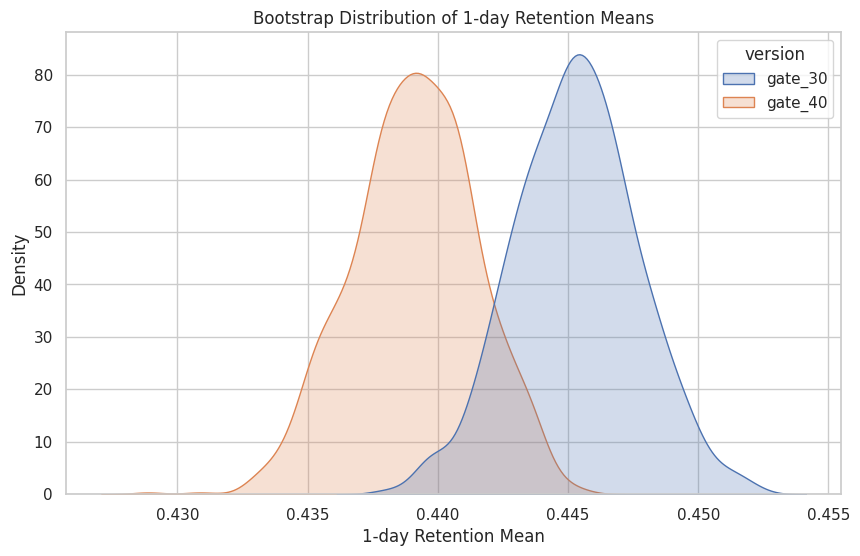

In [262]:
# Creating a list with bootstrapped means for each AB-group
boot_1d = []
for i in range(1000):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)

# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)

# Set up Seaborn style
sns.set(style="whitegrid")

# Create a Kernel Density Estimate plot of the bootstrap distributions
plt.figure(figsize=(10, 6))
sns.kdeplot(data=boot_1d, fill=True)
plt.xlabel('1-day Retention Mean')
plt.ylabel('Density')
plt.title('Bootstrap Distribution of 1-day Retention Means')
plt.show()

These two distributions above represent the bootstrap uncertainty over what the underlying 1-day retention could be for the two AB-groups. There seems to be some evidence of a difference, albeit small. Let's plot the % difference to have a closer look.

* The depicted distributions above reflect the outcome of bootstrapping, capturing the uncertainty surrounding the potential underlying 1-day retention rates for the two AB groups. While the observed disparity may be subtle, it suggests the existence of a discernible distinction. To gain a more nuanced understanding, it's advisable to create a visual representation highlighting the percentage difference between these retention rates.

For a clearer examination, we can compute the percentage difference between the two groups' 1-day retention rates for each bootstrap sample and construct a histogram to visualize these percentage differences.

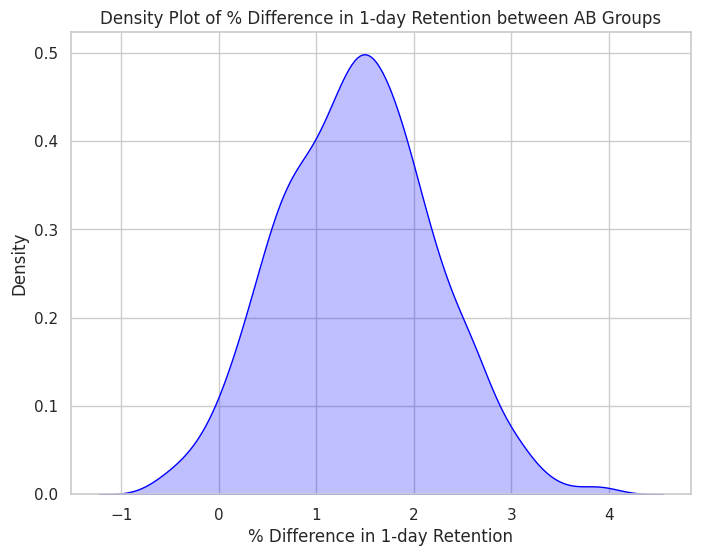

In [263]:
# Calculate percentage differences for each bootstrap sample
percentage_differences = ((boot_1d.gate_30 - boot_1d.gate_40) / boot_1d.gate_40) * 100
# Create a density plot to visualize the distribution of percentage differences
plt.figure(figsize=(8, 6))
sns.kdeplot(data=percentage_differences, fill=True, color='blue')
plt.xlabel('% Difference in 1-day Retention')
plt.ylabel('Density')
plt.title('Density Plot of % Difference in 1-day Retention between AB Groups')
plt.show()


In [265]:
# Calculating the probability that 1-day retention is greater when the gate is at level 30
print('Probability that 1-day retention is greater when the gate is at level 30:',(percentage_differences > 0).mean())

Probability that 1-day retention is greater when the gate is at level 30: 0.97


From this chart, we can see that the most likely % difference is around 1.5%, and that <strong>97% of the distribution is above 0%, in favor of a gate at level 30. </strong>

## Part 6. Comparing 7-day Retention  <a name= '5'></a>
The bootstrap analysis tells us that there is a high probability that 1-day retention is better when the gate is at level 30. However, since players have only been playing the game for one day, it is likely that most players haven't reached level 30 yet. That is, many players won't have been affected by the gate, even if it's as early as level 30. <p>But after having played for a week, more players should have reached level 40, and therefore it makes sense to also look at 7-day retention.

#### *Overall 7-day retention*

In [266]:
df.groupby('version')['retention_7'].sum() / df.groupby('version')['retention_7'].count()

version
gate_30    0.185990
gate_40    0.177362
Name: retention_7, dtype: float64

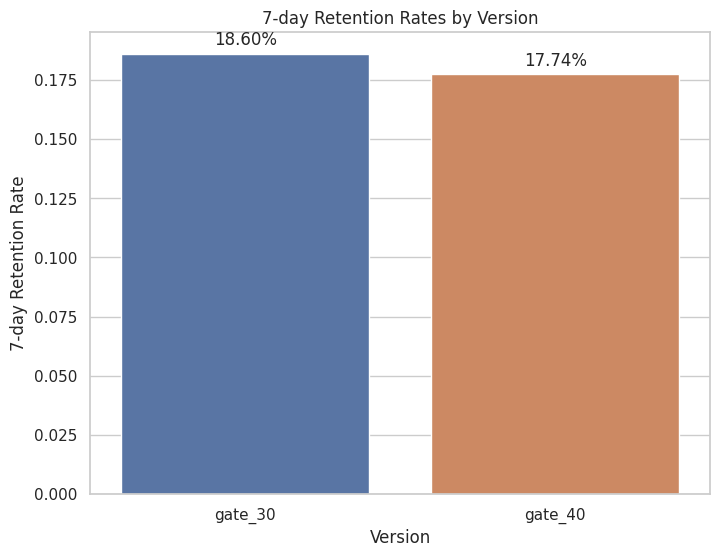

In [267]:
# Calculate 7-day retention rates for each version
retention_7_rates = df.groupby('version')['retention_7'].sum() / df.groupby('version')['retention_7'].count()

# Convert the result to a DataFrame for visualization
retention_7_rates = retention_7_rates.reset_index()
retention_7_rates.columns = ['version', '7-day Retention Rate']

# Set up Seaborn style
sns.set(style="whitegrid")

# Create a bar plot for 7-day retention rates
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='version', y='7-day Retention Rate', data=retention_7_rates)
plt.xlabel('Version')
plt.ylabel('7-day Retention Rate')
plt.title('7-day Retention Rates by Version')

# Adding value annotations on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2%}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

#### *7-day retention for each AB-group*

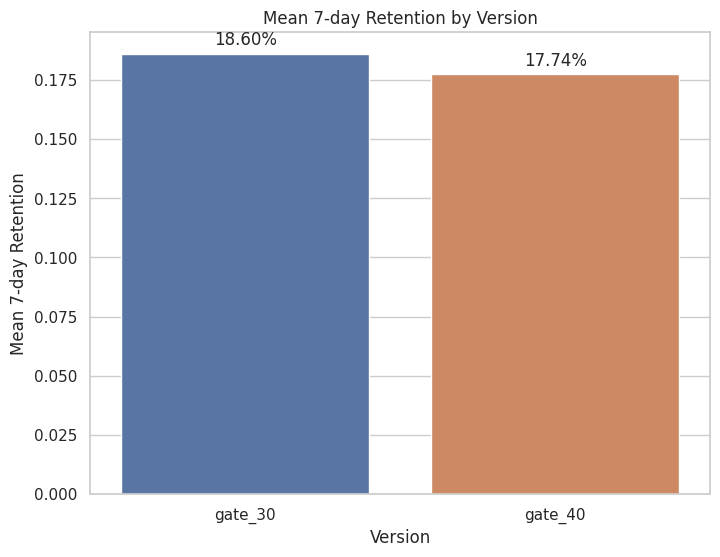

In [272]:
# Calculate mean 1-day retention for each version
retention_1_mean = df.groupby('version')['retention_7'].mean()

# Convert the result to a DataFrame for visualization
retention_1_mean = retention_1_mean.reset_index()
retention_1_mean.columns = ['version', 'Mean 7-day Retention']

# Set up Seaborn style
sns.set(style="whitegrid")

# Create a bar plot for mean 1-day retention
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='version', y='Mean 7-day Retention', data=retention_1_mean)
plt.xlabel('Version')
plt.ylabel('Mean 7-day Retention')
plt.title('Mean 7-day Retention by Version')

# Adding value annotations on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2%}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

* It's apparent that a marginal decrease in 1-day retention was observed when the gate was shifted to level 40 (17.74%), compared to the baseline when it stood at level 30 (18.6%). Although this shift is modest, it's essential to acknowledge that even minor fluctuations in retention rates can wield substantial influence. Yet, while the observed data presents a difference, it's vital to assess the degree of confidence regarding the assumption that a gate at level 40 will perform worse in the future.

#### *Bootstrapping*

In [275]:
df.sample(frac = 1,replace = True).groupby('version')['retention_7'].mean()

version
gate_30    0.185477
gate_40    0.177971
Name: retention_7, dtype: float64

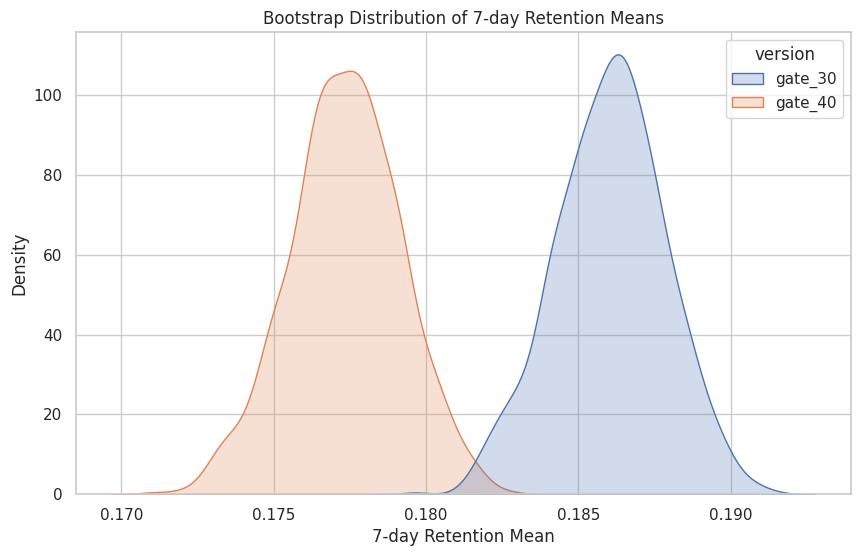

In [273]:
# Creating a list with bootstrapped means for each AB-group
boot_7d = []
for i in range(1000):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)

# Transforming the list to a DataFrame
boot_7d = pd.DataFrame(boot_7d)

# Set up Seaborn style
sns.set(style="whitegrid")

# Create a Kernel Density Estimate plot of the bootstrap distributions
plt.figure(figsize=(10, 6))
sns.kdeplot(data=boot_7d, fill=True)
plt.xlabel('7-day Retention Mean')
plt.ylabel('Density')
plt.title('Bootstrap Distribution of 7-day Retention Means')
plt.show()

**Insights:**
<ul>
    <li><strong>Like with 1-day retention, 7-day retention is slightly lower when the gate is at level 40</strong> (18.2%) than when the gate is at level 30 (19.0%).
    <li><strong>This difference is also larger than for 1-day retention</strong>, presumably because more players have had time to hit the first gate.
    <li> <strong>The overall 7-day retention is lower than the overall 1-day retention</strong>; fewer people play a game a week after installing than a day after installing.
</ul>
<p>But as before, let's use bootstrap analysis to figure out how certain we should be of the difference between the AB-groups.</p>

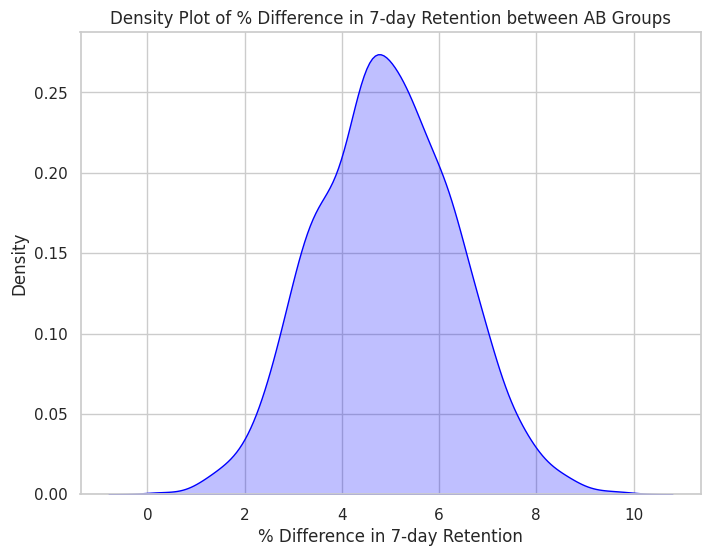

In [278]:
# Calculate percentage differences for each bootstrap sample
percentage_differences_7 = ((boot_7d.gate_30 - boot_7d.gate_40) / boot_7d.gate_40) * 100
# Create a density plot to visualize the distribution of percentage differences
plt.figure(figsize=(8, 6))
sns.kdeplot(data=percentage_differences_7, fill=True, color='blue')
plt.xlabel('% Difference in 7-day Retention')
plt.ylabel('Density')
plt.title('Density Plot of % Difference in 7-day Retention between AB Groups')
plt.show()

In [279]:
# Calculating the probability that 1-day retention is greater when the gate is at level 30
print('Probability that 7-day retention is greater when the gate is at level 30:',(percentage_differences_7 > 0).mean())

Probability that 7-day retention is greater when the gate is at level 30: 1.0


## Part 7. Conclusion  <a name= '6'></a>
<p>The bootstrap result tells us that <strong>there is strong evidence that 7-day retention is higher when the gate is at level 30 than when it is at level 40.</strong> The conclusion is: If we want to keep retention high — both 1-day and 7-day retention — we should not move the gate from level 30 to level 40.
<p>There are, of course, other metrics we could look at, like the number of game rounds played or how much in-game purchases are made by the two AB-groups. But retention <em>is</em> one of the most important metrics. If we don't retain our player base, it doesn't matter how much money they spend in-game.</p>


<p>So, why is retention higher when the gate is positioned earlier? One could expect the opposite: The later the obstacle, the longer people are going to engage with the game. But this is not what the data tells us. The theory of <em>hedonic adaptation</em> can give one explanation for this.
<p>In short, <strong>hedonic adaptation is the tendency for people to get less and less enjoyment out of a fun activity over time if that activity is undertaken continuously.</strong> By forcing players to take a break when they reach a gate, their enjoyment of the game is prolonged. But <strong>when the gate is moved to level 40, fewer players make it far enough, and they are more likely to quit the game because they simply got bored of it. </strong></p>